# 1. Import Module & Data

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
from matplotlib import figure
import matplotlib.pyplot as plt
import math
import os
import time
import random
import gc
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import seaborn as sns

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = "2"

In [3]:
data_folder = '../data/'
os.makedirs(data_folder, exist_ok=True)

df = pd.read_csv(data_folder + 'sp500_intra.csv')
df = df.iloc[:, 1:]
df

,MMM,AOS,ABT,ABBV,ABMD,ACN,ATVI,ADM,ADBE,ADP,...,WHR,WMB,WYNN,XEL,XYL,YUM,ZBRA,ZBH,ZION,ZTS
0,178.43,73.65,129.2600,115.360,335.000000,359.600,78.7500,64.320,651.440,224.41,...,211.7650,28.250,89.700,64.28,131.15,125.436,532.80,143.5900,63.77,217.220
1,178.58,73.99,129.2450,115.460,334.600000,359.805,79.0600,64.425,651.920,224.15,...,211.7575,28.270,89.550,64.28,131.15,125.540,532.80,143.5900,63.88,217.500
2,178.52,74.04,129.3100,115.530,334.795833,359.530,79.3620,64.380,652.670,223.71,...,211.7500,28.300,89.205,64.25,131.83,125.470,533.53,143.9000,64.08,217.340
3,178.62,74.11,129.5000,115.630,334.991667,359.000,79.4202,64.340,653.120,223.80,...,211.5600,28.285,89.440,64.28,131.82,125.700,534.16,144.2581,63.93,217.400
4,178.52,74.26,129.3100,115.240,335.187500,358.800,79.6600,64.225,651.480,223.15,...,211.9100,28.300,89.980,64.23,131.81,125.620,534.79,144.8400,63.94,216.735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31013,143.81,67.69,118.7901,145.100,306.705000,316.110,80.9900,75.920,464.480,200.42,...,198.1000,29.940,86.720,64.83,87.93,121.680,415.56,123.4900,67.08,191.555
31014,143.77,67.79,118.8500,145.100,306.345000,315.880,80.9600,75.940,463.600,200.34,...,198.0200,29.940,86.620,64.83,87.79,121.660,415.27,123.4650,67.03,191.560
31015,143.77,67.79,118.8200,145.130,306.800000,315.925,80.9950,75.950,463.880,200.26,...,198.0000,29.945,86.690,64.84,87.79,121.650,415.23,123.5000,67.10,191.260
31016,143.47,67.66,118.5550,145.045,306.560000,315.260,80.9900,75.830,463.585,199.87,...,197.5700,29.905,86.470,64.77,87.69,121.320,414.46,123.3000,66.91,190.880


In [4]:
#Feature Engineering Class 
class FeatureEngineering:
    def __init__(self, stock_name):
        self.stock_name = stock_name

    #단순 이동 평균
    def SMA(self,  data, column='Close', period=30):
        return data[column].rolling(period).mean()

    #지수 이동 평균
    def EMA(self, data, period=20, column='Close'):
        return data[column].ewm(span=period, adjust=False).mean()
    
    #볼린저밴드
    def Bollingerband(self, data, period=20, column='Close'):
        data[column+'_SMA'] = self.SMA(data, column=column, period=period)
        data[column+'_UB'] = data[column+'_SMA'] + 2*data[column+'_SMA'].rolling(20).std()
        data[column+'_LB'] = data[column+'_SMA'] - 2*data[column+'_SMA'].rolling(20).std()
        
        return data
    
    #MACD
    def MACD(self, data, period_long=26, period_short=12, period_signal=9, column='Close'):
        data[column+'_EMA'] = self.EMA(data, period=20 ,column=column)
        
        data[column+'_ShortEMA'] = self.EMA(data, period_short, column=column)

        data[column+'_LongEMA'] = self.EMA(data, period_long, column=column)

        data[column+'_MACD'] = data[column+'_ShortEMA']- data[column+'_LongEMA']

              #signal
        data[column+'_Signal_Line'] = self.EMA(data, period_signal, column=column+'_MACD')

        return data
    
    #Momentum
    def Momentum(self, data, period=7, column='Close'):
        data[column+'_7D'] = data[column].shift(period)
        data[column+'_1D'] = data[column].shift(1)
        data[column+'_Momentum'] = data[column+'_1D'] / data[column+'_7D'] - 1
        
        return data
    
    #RSI
    def RSI(self, data, period=14, column='Close'):
        delta = data[column].diff(1)
        delta = delta.dropna()

        up = delta.copy()
        down = delta.copy()
        up[up<0] = 0
        down[down>0] = 0
        data[column+'_up'] = up
        data[column+'_down'] = down

        AVG_Gain = self.SMA(data, period=period, column=column+'_up')
        AVG_Loss = abs(self.SMA(data, period=period, column=column+'_down'))
        RS = AVG_Gain / AVG_Loss

        RSI = 100.0 - (100.0/(1.0+RS))
        data[column+'_RSI'] = RSI
  
        return data
    
    #Get feature engineered data
    def get_data(self, train):
        #print('Feature Engineering...')
        
        self.train = train
        c = self.stock_name
        
        self.train = self.Bollingerband(self.train, column=c)
        self.train = self.MACD(self.train, column=c)
        self.train = self.Momentum(self.train, column=c)
        self.train = self.RSI(self.train, column=c)
        
        #print("Done!")
        
        return self.train

In [5]:
fe = FeatureEngineering('AAPL')
df = fe.get_data(df.loc[:, ['AAPL']])

In [6]:
df.dropna(inplace=True)

In [7]:
train = df[:25000]
valid = df[25000:25000+3000]
test = df[25000+3000:]

print(len(train), len(valid), len(test))

sc = MinMaxScaler()
sc.fit(train.values)
train_sc = pd.DataFrame(sc.transform(train.values), columns=df.columns)
valid_sc = pd.DataFrame(sc.transform(valid.values), columns=df.columns)
test_sc = pd.DataFrame(sc.transform(test.values), columns=df.columns)

25000 3000 2980


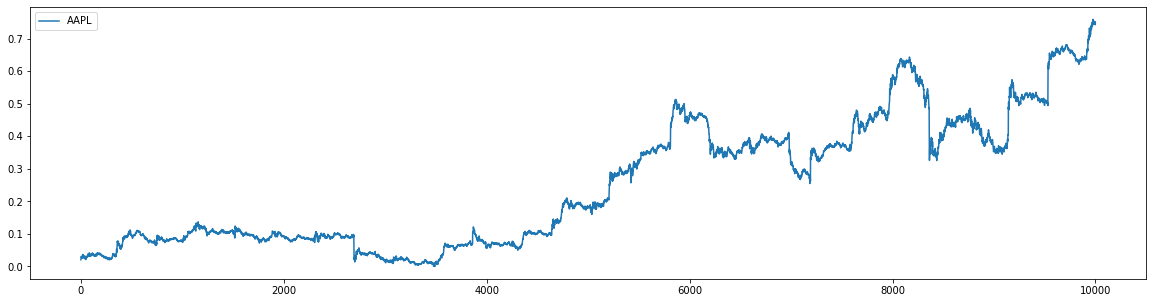

In [8]:
plt.figure(figsize=(20,5))
plt.plot(train_sc.iloc[:10000, 0], label=train_sc.columns[0])
plt.legend()
plt.show()

In [9]:
from torch import nn
from torch.utils.data import Dataset, WeightedRandomSampler
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F
import torch

import os
import statistics
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import json
import matplotlib.pyplot as plt

SEED = 10
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)

In [10]:
class MyDataset(Dataset):
    def __init__(self, data, window, pred):
        self.data = torch.Tensor(data)
        self.window = window
        self.pred = pred
        
        self.shape = self.__getshape__()
        self.size = self.__getsize__()

    def __getitem__(self, index):
        x = self.data[index:index+self.window, :]
        y = self.data[index+self.window+self.pred, 0]
        return x, y

    def __len__(self):
        return len(self.data) - self.window - self.pred
    
    def __getshape__(self):
        return (self.__len__(), *self.__getitem__(0)[0].shape) # row, col
    
    def __getsize__(self):
        return (self.__len__())

In [11]:
batch_size = 64
num_workers = 4
pin_memory = True
device = 'cuda'
num_epoch = 200
lr = 1e-4
window = 60
pred_step = 20

In [12]:
train_dataset = MyDataset(train_sc.values, window, pred_step)
valid_dataset = MyDataset(valid_sc.values, window, pred_step)
test_dataset = MyDataset(test_sc.values, window, pred_step)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                     drop_last=False, 
                                     num_workers=num_workers, pin_memory=pin_memory, shuffle=True) 
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, 
                                     drop_last=False, 
                                     num_workers=num_workers, pin_memory=pin_memory, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, 
                                     drop_last=False, 
                                     num_workers=num_workers, pin_memory=pin_memory, shuffle=False)

# 2. CNN Model (similar architecture w DynamicRouting CapsNet)

In [13]:
result_folder = '../check/gru/stock_prediction/'
os.makedirs(result_folder, exist_ok=True)

In [14]:
class GRU(nn.Module):
    def __init__(self, in_features, out_features, hidden_dim):
        super(GRU, self).__init__()
        
        self.n_layers = 3
        self.hidden_size=hidden_dim
        
        self.leakyrelu = nn.LeakyReLU(0.1)
        
        self.gru = nn.GRU(input_size=in_features, hidden_size=self.hidden_size, batch_first=True,
                          num_layers=self.n_layers, dropout=0.1)
        
        self.out = nn.Sequential(
            nn.Linear(self.hidden_size, 64),
            self.leakyrelu,
            nn.Linear(64, 32), 
            self.leakyrelu,
            nn.Linear(32, out_features)
        )
        
    def forward(self, x):
        weight = next(self.parameters()).data
        h = weight.new(self.n_layers, x.shape[0], self.hidden_size).zero_()
        
        rnn_output, h = self.gru(x,h)
        outputs = self.out(h[-1, :, :].squeeze(0))
        
        return outputs

In [15]:
model = GRU(in_features= 15,
            out_features=1, 
            hidden_dim = 64).to(device) 

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = ReduceLROnPlateau(optimizer, 'min')
criterion = nn.MSELoss()

In [16]:
model

GRU(
  (leakyrelu): LeakyReLU(negative_slope=0.1)
  (gru): GRU(15, 64, num_layers=3, batch_first=True, dropout=0.1)
  (out): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): LeakyReLU(negative_slope=0.1)
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): LeakyReLU(negative_slope=0.1)
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
)

# Model Training & Evaluation #

In [17]:
train_loss_list = []
valid_loss_list = []
    
for epoch in range(0, num_epoch+1):
    model = model.train()

    train_loss = []
    for (x, y) in tqdm(train_loader, leave=False):
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
        outputs = model(x)

        loss = torch.sqrt(criterion(outputs.squeeze(), y.squeeze()))
        
        loss.backward()
        optimizer.step()
        
        train_loss.append(loss.item())

    train_loss = np.mean(train_loss)
    
    model = model.eval()
    predictions = []
    answers = []
    valid_loss = []
    with torch.no_grad():
        for (x, y) in tqdm(valid_loader, leave=False):
            x = x.to(device)
            y = y.to(device)
            answers.extend(y.detach().cpu().numpy())

            outputs = model(x)

            loss = torch.sqrt(criterion(outputs.squeeze(), y.squeeze()))
        
            predictions.extend(outputs.squeeze().detach().cpu().numpy())
            valid_loss.append(loss.item())    

    valid_loss = np.mean(valid_loss)
    
    print("epoch: {}/{} | trn_loss: {:.4f} | val_loss: {:.4f}".format(
                epoch, num_epoch, train_loss, valid_loss
            ))
    train_loss_list.append(train_loss)
    valid_loss_list.append(valid_loss)
    
    """
    if epoch % 20 ==0 :       
        torch.save({
            'epoch': epoch,
            'loss': valid_loss_list[-1],
            'model_state_dict' : model.state_dict(),
            'optimizer_state_dict' : optimizer.state_dict(),
            'criterion' : criterion
        }, result_folder + f'cnn-swcapsule-pred-stock-best.pt')s
    """
    
    if (epoch==0) or (epoch>0 and (min(valid_loss_list[:-1])>valid_loss_list[-1])):
        torch.save({
            'epoch': epoch,
            'loss': valid_loss_list[-1],
            'model_state_dict' : model.state_dict(),
            'optimizer_state_dict' : optimizer.state_dict(),
            'criterion' : criterion
        }, result_folder + f'gru-pred-stock-best.pt')

  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

epoch: 0/200 | trn_loss: 0.2180 | val_loss: 0.0186


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

epoch: 1/200 | trn_loss: 0.0268 | val_loss: 0.0198


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

epoch: 2/200 | trn_loss: 0.0252 | val_loss: 0.0148


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

epoch: 3/200 | trn_loss: 0.0246 | val_loss: 0.0179


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

epoch: 4/200 | trn_loss: 0.0242 | val_loss: 0.0171


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

epoch: 5/200 | trn_loss: 0.0237 | val_loss: 0.0178


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

epoch: 6/200 | trn_loss: 0.0233 | val_loss: 0.0154


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

epoch: 7/200 | trn_loss: 0.0232 | val_loss: 0.0144


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

epoch: 8/200 | trn_loss: 0.0230 | val_loss: 0.0190


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

epoch: 9/200 | trn_loss: 0.0229 | val_loss: 0.0146


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

epoch: 10/200 | trn_loss: 0.0226 | val_loss: 0.0144


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

epoch: 11/200 | trn_loss: 0.0227 | val_loss: 0.0154


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

epoch: 12/200 | trn_loss: 0.0225 | val_loss: 0.0186


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

epoch: 13/200 | trn_loss: 0.0223 | val_loss: 0.0148


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

epoch: 14/200 | trn_loss: 0.0222 | val_loss: 0.0173


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

epoch: 15/200 | trn_loss: 0.0223 | val_loss: 0.0155


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

epoch: 16/200 | trn_loss: 0.0221 | val_loss: 0.0147


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

epoch: 17/200 | trn_loss: 0.0220 | val_loss: 0.0144


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

epoch: 18/200 | trn_loss: 0.0219 | val_loss: 0.0162


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

epoch: 19/200 | trn_loss: 0.0220 | val_loss: 0.0143


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

epoch: 20/200 | trn_loss: 0.0218 | val_loss: 0.0171


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

epoch: 21/200 | trn_loss: 0.0217 | val_loss: 0.0145


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

epoch: 22/200 | trn_loss: 0.0218 | val_loss: 0.0158


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

epoch: 23/200 | trn_loss: 0.0216 | val_loss: 0.0149


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

epoch: 24/200 | trn_loss: 0.0215 | val_loss: 0.0149


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

epoch: 25/200 | trn_loss: 0.0215 | val_loss: 0.0144


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

epoch: 26/200 | trn_loss: 0.0216 | val_loss: 0.0142


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

epoch: 27/200 | trn_loss: 0.0216 | val_loss: 0.0149


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

epoch: 28/200 | trn_loss: 0.0217 | val_loss: 0.0144


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

epoch: 29/200 | trn_loss: 0.0213 | val_loss: 0.0145


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

epoch: 30/200 | trn_loss: 0.0212 | val_loss: 0.0182


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

epoch: 31/200 | trn_loss: 0.0213 | val_loss: 0.0179


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

epoch: 32/200 | trn_loss: 0.0213 | val_loss: 0.0145


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

epoch: 33/200 | trn_loss: 0.0213 | val_loss: 0.0146


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

epoch: 34/200 | trn_loss: 0.0211 | val_loss: 0.0150


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

epoch: 35/200 | trn_loss: 0.0211 | val_loss: 0.0147


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

epoch: 36/200 | trn_loss: 0.0211 | val_loss: 0.0149


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

epoch: 37/200 | trn_loss: 0.0209 | val_loss: 0.0181


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

epoch: 38/200 | trn_loss: 0.0210 | val_loss: 0.0154


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

epoch: 39/200 | trn_loss: 0.0209 | val_loss: 0.0143


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

epoch: 40/200 | trn_loss: 0.0210 | val_loss: 0.0142


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

epoch: 41/200 | trn_loss: 0.0208 | val_loss: 0.0148


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

epoch: 42/200 | trn_loss: 0.0209 | val_loss: 0.0147


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

epoch: 43/200 | trn_loss: 0.0208 | val_loss: 0.0142


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

epoch: 44/200 | trn_loss: 0.0207 | val_loss: 0.0159


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

epoch: 45/200 | trn_loss: 0.0206 | val_loss: 0.0141


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

epoch: 46/200 | trn_loss: 0.0205 | val_loss: 0.0147


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

epoch: 47/200 | trn_loss: 0.0206 | val_loss: 0.0147


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

epoch: 48/200 | trn_loss: 0.0206 | val_loss: 0.0150


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

epoch: 49/200 | trn_loss: 0.0205 | val_loss: 0.0147


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

epoch: 50/200 | trn_loss: 0.0207 | val_loss: 0.0142


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

epoch: 51/200 | trn_loss: 0.0205 | val_loss: 0.0183


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

epoch: 52/200 | trn_loss: 0.0206 | val_loss: 0.0159


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

epoch: 53/200 | trn_loss: 0.0204 | val_loss: 0.0142


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

epoch: 54/200 | trn_loss: 0.0204 | val_loss: 0.0150


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

epoch: 55/200 | trn_loss: 0.0204 | val_loss: 0.0141


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

epoch: 56/200 | trn_loss: 0.0204 | val_loss: 0.0143


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

epoch: 57/200 | trn_loss: 0.0203 | val_loss: 0.0143


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

epoch: 58/200 | trn_loss: 0.0204 | val_loss: 0.0143


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

epoch: 59/200 | trn_loss: 0.0203 | val_loss: 0.0142


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

epoch: 60/200 | trn_loss: 0.0204 | val_loss: 0.0148


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

epoch: 61/200 | trn_loss: 0.0203 | val_loss: 0.0141


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

epoch: 62/200 | trn_loss: 0.0204 | val_loss: 0.0140


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

epoch: 63/200 | trn_loss: 0.0203 | val_loss: 0.0141


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

epoch: 64/200 | trn_loss: 0.0204 | val_loss: 0.0164


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

epoch: 65/200 | trn_loss: 0.0202 | val_loss: 0.0140


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

epoch: 66/200 | trn_loss: 0.0202 | val_loss: 0.0140


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

epoch: 67/200 | trn_loss: 0.0203 | val_loss: 0.0142


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

epoch: 68/200 | trn_loss: 0.0203 | val_loss: 0.0140


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

epoch: 69/200 | trn_loss: 0.0201 | val_loss: 0.0141


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

epoch: 70/200 | trn_loss: 0.0206 | val_loss: 0.0160


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

epoch: 71/200 | trn_loss: 0.0202 | val_loss: 0.0146


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

epoch: 72/200 | trn_loss: 0.0202 | val_loss: 0.0145


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

epoch: 73/200 | trn_loss: 0.0200 | val_loss: 0.0140


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

epoch: 74/200 | trn_loss: 0.0201 | val_loss: 0.0145


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

epoch: 75/200 | trn_loss: 0.0202 | val_loss: 0.0144


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

epoch: 76/200 | trn_loss: 0.0200 | val_loss: 0.0142


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

epoch: 77/200 | trn_loss: 0.0201 | val_loss: 0.0150


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

epoch: 78/200 | trn_loss: 0.0200 | val_loss: 0.0158


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

epoch: 79/200 | trn_loss: 0.0201 | val_loss: 0.0141


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

epoch: 80/200 | trn_loss: 0.0202 | val_loss: 0.0142


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

epoch: 81/200 | trn_loss: 0.0201 | val_loss: 0.0141


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

epoch: 82/200 | trn_loss: 0.0201 | val_loss: 0.0140


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

epoch: 83/200 | trn_loss: 0.0200 | val_loss: 0.0159


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

epoch: 84/200 | trn_loss: 0.0199 | val_loss: 0.0143


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

epoch: 85/200 | trn_loss: 0.0202 | val_loss: 0.0191


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

epoch: 86/200 | trn_loss: 0.0201 | val_loss: 0.0141


  0%|          | 0/390 [00:00<?, ?it/s]

Exception in thread Thread-180:
Traceback (most recent call last):
  File "/data4/jihyeon/anaconda3/envs/pytorch/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/data4/jihyeon/anaconda3/envs/pytorch/lib/python3.8/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/data4/jihyeon/anaconda3/envs/pytorch/lib/python3.8/site-packages/torch/utils/data/_utils/pin_memory.py", line 28, in _pin_memory_loop
    r = in_queue.get(timeout=MP_STATUS_CHECK_INTERVAL)
  File "/data4/jihyeon/anaconda3/envs/pytorch/lib/python3.8/multiprocessing/queues.py", line 116, in get
    return _ForkingPickler.loads(res)
  File "/data4/jihyeon/anaconda3/envs/pytorch/lib/python3.8/site-packages/torch/multiprocessing/reductions.py", line 289, in rebuild_storage_fd
    fd = df.detach()
  File "/data4/jihyeon/anaconda3/envs/pytorch/lib/python3.8/multiprocessing/resource_sharer.py", line 58, in detach
    return reduction.recv_handle(conn)
  File "/data4

KeyboardInterrupt: 

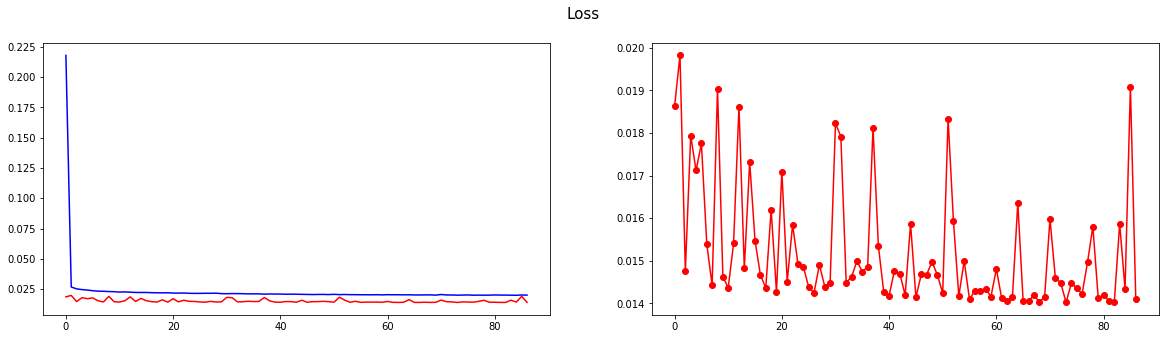

In [18]:
fig, ax = plt.subplots(1,2,figsize=(20,5))

ax0 = ax[0]
ax0.plot(train_loss_list, c= 'blue')
ax0.plot(valid_loss_list, c='red')

ax1 = ax[1]
ax1.plot(valid_loss_list, c='red', marker='o')

fig.suptitle("Loss", fontsize=15)
plt.savefig(result_folder+'gru_loss.png')

In [19]:
pd.DataFrame([train_loss_list, valid_loss_list]).to_csv(result_folder + 'gru_loss.csv', index=0)

### Performance Evaluation

In [20]:
checkpoint = torch.load(result_folder + 'gru-pred-stock-best.pt')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
criterion = checkpoint['criterion']
print(checkpoint['epoch'], checkpoint['loss'])

73 0.014023221310471063


In [21]:
model = model.eval()
test_loss = []
answers = []
predictions = []

with torch.no_grad():
    for (x, y) in tqdm(test_loader, leave=False):
        x = x.to(device)
        y = y.to(device)

        outputs = model(x)
        
        loss = torch.sqrt(criterion(outputs.squeeze(), y.squeeze()))
        
        answers.extend((y.squeeze()).squeeze().detach().cpu().numpy())
        predictions.extend((outputs.squeeze()).squeeze().detach().cpu().numpy())
        test_loss.append(loss.item())  
        
test_loss = np.mean(test_loss)
print(f'test loss: {test_loss}')

  0%|          | 0/46 [00:00<?, ?it/s]

test loss: 0.018649233004037778


In [22]:
min_ = sc.data_min_[0]
max_ = sc.data_max_[0]

In [23]:
answers = pd.DataFrame(answers)
answers = pd.concat([answers, test_sc.iloc[:, 1:]])
predictions = pd.DataFrame(predictions)
predictions = pd.concat([predictions, test_sc.iloc[:, 1:]])

result_ans = pd.DataFrame(sc.inverse_transform(answers), columns = test_sc.columns)
result_pred= pd.DataFrame(sc.inverse_transform(predictions), columns = test_sc.columns)


result_ans.to_csv(result_folder + 'result_ans.csv')
result_pred.to_csv(result_folder + 'result_pred.csv')

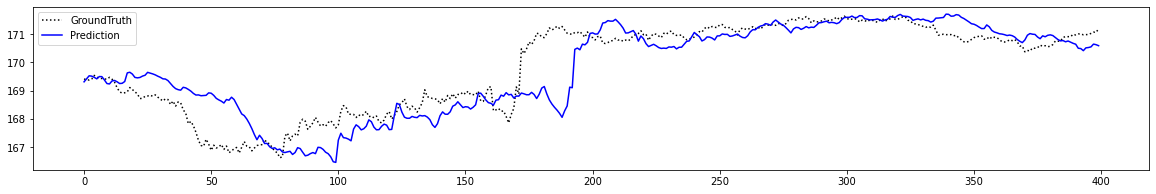

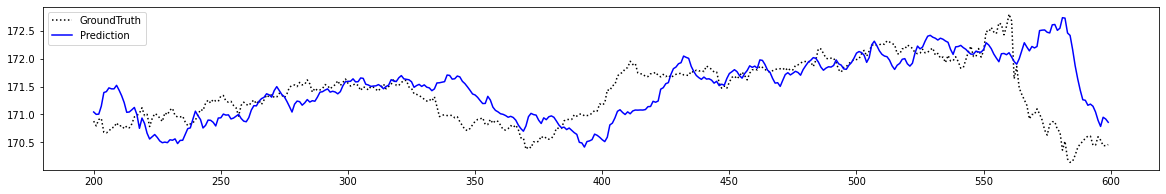

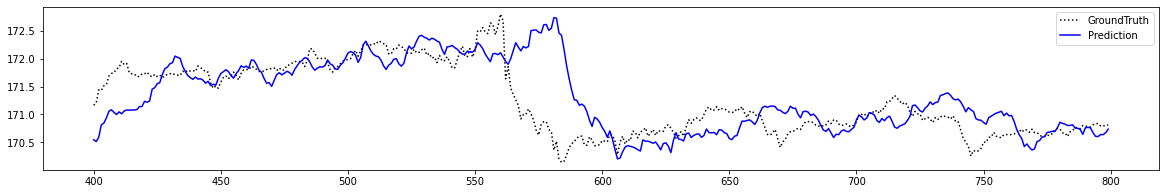

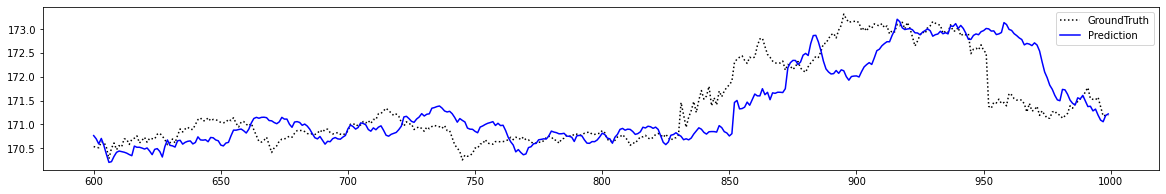

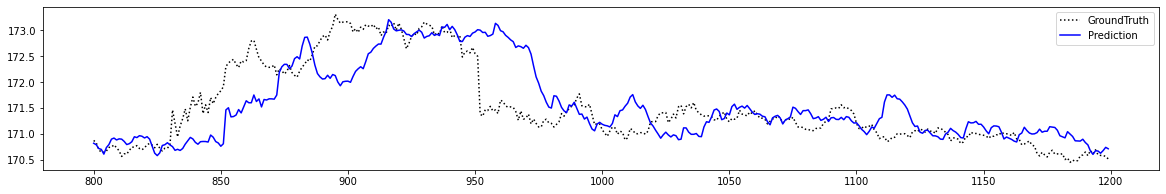

In [25]:
for i in range(0, 1000,200):
    plt.figure(figsize=(20,3))
    plt.plot(result_ans.iloc[i:i+400, 0], c='black', ls=':', label = 'GroundTruth')
    plt.plot(result_pred.iloc[i:i+400, 0], c='blue', label='Prediction')
    plt.legend()
    plt.savefig(result_folder + f'sample{i}_predresult.png')